# Data Prep with Time Series 

In this lesson we will prepare the time series data we have previously acquired.

In [1]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from acquire import get_store_data

## Acquire 

We'll start by loading up the data from our acquire module.

In [2]:
df = get_store_data()
df.head(3)

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_date,sale_amount,store_address,store_zipcode,store_city,store_state
0,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,2013-01-01,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
1,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,2,2013-01-02,11,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
2,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,3,2013-01-03,14,12125 Alamo Ranch Pkwy,78253,San Antonio,TX


## Summarize

Before we dive into the data preperation, we should get an idea of the shape of the data. We'll get a sense for the number of rows, column names, datatypes, descriptive statistics, number and percent of missing values. We'll also get a broad overview of the kind of data in each column.

In [3]:
df.shape # number of rows and columns

(913000, 14)

In [4]:
df.isnull().sum() # number null values in each column

store_id         0
item_id          0
item_upc14       0
item_upc12       0
item_brand       0
item_name        0
item_price       0
sale_id          0
sale_date        0
sale_amount      0
store_address    0
store_zipcode    0
store_city       0
store_state      0
dtype: int64

In [5]:
df.store_id.unique() # unique values of  store_id

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [6]:
df.item_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [7]:
df.sale_date.nunique() # number of unique sales dates

1826

In [8]:
df.sale_date.min(), df.sale_date.max()

('2013-01-01', '2017-12-31')

In [9]:
df.sale_amount.describe()

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sale_amount, dtype: float64

Takeaways so far:

- 913k rows
- No missing values
- `store_id` ranges from 1-10
- `item_id` ranges from 1-50
- there are 1826 unique days in our data
- sale amount ranges from \\$0 to \\$231

## Prepare

The most common activity in preparing time series data is setting dates to datetime types using `pd.to_datetime`. 

Another common activity is looking at the frequency of the data and gaps in time or null values. As part of this, we'll investigate our data and figure out what each row represents and ask if that is what we want.

### Set Datetime Index 

In [10]:
# Reassign the sale_date column to be a datetime type
df.sale_date = pd.to_datetime(df.sale_date)

# Sort rows by the date and then set the index as that date
df = df.set_index("sale_date").sort_index()

### Defining Our Observations

Here we ask ourselves what each row (or observation) represents or measures.

In [11]:
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,sale_amount,store_address,store_zipcode,store_city,store_state
sale_date,,,,,,,,,,,,,
2013-01-01,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
2013-01-01,3,17,88313590791,88313590791,Ducal,Ducal Refried Red Beans,1.16,295813,26,2118 Fredericksburg Rdj,78201,San Antonio,TX
2013-01-01,10,7,70177154004,70177154004,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,125995,32,8503 NW Military Hwy,78231,San Antonio,TX
2013-01-01,3,18,21200725340,21200725340,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,314073,45,2118 Fredericksburg Rdj,78201,San Antonio,TX
2013-01-01,3,19,41520035646,41520035646,Careone,Careone Family Comb Set - 8 Ct,0.74,332333,34,2118 Fredericksburg Rdj,78201,San Antonio,TX


Notice that each row is not a single day. With datetime indeces, we can have multiple rows at the same datetime value. It looks like each individual row, that is, each observation, is a sales of a specific item at a specific store, one sale.

We can confirm this by taking a look at the `sale_id` column.

In [12]:
df.shape[0], df.sale_id.nunique()

(913000, 913000)

It looks like each sale id does uniquely identify each row and each row is a combination of one item sold at one store. So each observation is the quantity of items sold on one day, in one store. 

### Let's get to know our data a bit better
- Currently, the dataframe has one row per sold item, but what if we need more or less granularity?
- Let's get to know our data then consider what it means to define our observation in different ways.
- We'll also look at different time-windows for our data.

#### Plot Target Variable Over Time
Generate a quick plot of our target variable over time, the variable we wish to forecast or predict. 
We will first aggregate the `sale_amount` by `sale_date` using `sum()`, i.e. group by sale_date and sum the sale_amount. We will then do a quick plot of this aggregated data. 

<Axes: xlabel='sale_date'>

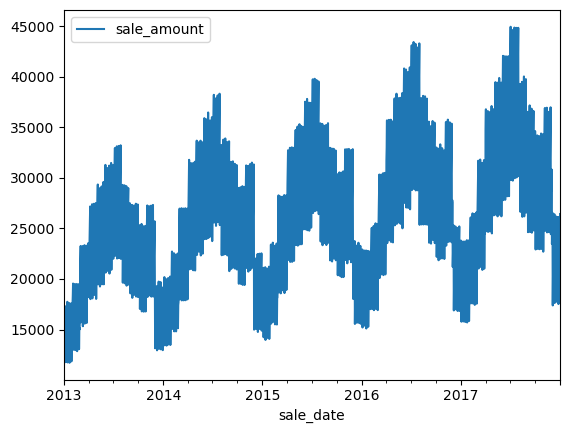

In [13]:
by_date = df.groupby(['sale_date']).sale_amount.sum().reset_index()
by_date.plot(x='sale_date', y='sale_amount')

Is each store equally represented in this dataset?

In [14]:
# Number of observations per store = number of item-transactions per store.
df.store_id.value_counts()

store_id
1     91300
3     91300
10    91300
9     91300
2     91300
4     91300
6     91300
8     91300
7     91300
5     91300
Name: count, dtype: int64

Is each item equally represented in this dataset?

In [15]:
df.item_id.value_counts().sort_index()

item_id
1     18260
2     18260
3     18260
4     18260
5     18260
6     18260
7     18260
8     18260
9     18260
10    18260
11    18260
12    18260
13    18260
14    18260
15    18260
16    18260
17    18260
18    18260
19    18260
20    18260
21    18260
22    18260
23    18260
24    18260
25    18260
26    18260
27    18260
28    18260
29    18260
30    18260
31    18260
32    18260
33    18260
34    18260
35    18260
36    18260
37    18260
38    18260
39    18260
40    18260
41    18260
42    18260
43    18260
44    18260
45    18260
46    18260
47    18260
48    18260
49    18260
50    18260
Name: count, dtype: int64

It looks like both items and stores are equally represented, that is, each store shows up the same number of times and so does each item.

### Explore Stores + Items

There are 50 different items and there were 18,260 sales for each item. 

We will explore the data behind the unique combinations of store & item.   
For example, what was the first sale date for each store/item combination?
What was the last sale date?   
On how many different days was each item sold at each store?   

First, we will want to reset the index so that sale_date becomes a feature we can use in an aggregate.   
Next, we will group by store_id and item_id. 
Finally, we will perform the aggregates needed to answer the questions. 

Let's find the first sale date for each store/item combination:

In [16]:
first_sale = df.reset_index().groupby(['store_id','item_id']).sale_date.min()
first_sale.head()

store_id  item_id
1         1         2013-01-01
          2         2013-01-01
          3         2013-01-01
          4         2013-01-01
          5         2013-01-01
Name: sale_date, dtype: datetime64[ns]

Is Jan 1, 2013 the first date for all store/item combinations?

In [17]:
# get the unique dates from first_sale_per_storeitem
first_sale.unique() # if there's only one unique value, then YES!

<DatetimeArray>
['2013-01-01 00:00:00']
Length: 1, dtype: datetime64[ns]

In [18]:
# What is the last (i.e. most recent) sale date for each store/item combination?

In [19]:
last_sale = df.reset_index().groupby(['store_id','item_id']).sale_date.max()
last_sale.head()

store_id  item_id
1         1         2017-12-31
          2         2017-12-31
          3         2017-12-31
          4         2017-12-31
          5         2017-12-31
Name: sale_date, dtype: datetime64[ns]

Is Dec 31, 2107 the last date for all store/item combinations? 

In [20]:
last_sale.unique() # if there's only one unique value, then YES!

<DatetimeArray>
['2017-12-31 00:00:00']
Length: 1, dtype: datetime64[ns]

On how many different days was each item sold at each store?

In [21]:
days_per_store_per_item = df.reset_index().groupby(['store_id','item_id']).sale_date.nunique()
days_per_store_per_item.head()

store_id  item_id
1         1          1826
          2          1826
          3          1826
          4          1826
          5          1826
Name: sale_date, dtype: int64

Did every store sell at least one of every item on every day in the data's time span? 

In [22]:
# If there's only one unique value in the list, then YES!
# every store sold every item on every one of the 1826 days in our data history.
days_per_store_per_item.unique() 

array([1826])

## Check for time gaps in the data

While there might not be nulls present in our data, the time observations may leave a gap that we need to be able to detect. We can check the number of rows vs. the number of days that should exist between the minimum and maximum dates to see if there are any missing days.

In [23]:
print('Number of rows:', df.index.nunique())
n_days = df.index.max() - df.index.min() + pd.Timedelta('1d')
print(f"Number of days between first and last day:", n_days)

Number of rows: 1826
Number of days between first and last day: 1826 days 00:00:00


### Reproducibility

We'll now encapsulate all the preparation work that we've done into a single function, and store that function in `prepare.py` so that we can reference it again later.

In [24]:
def prep_store_data(df):
    return df.asign(sale_date=pd.to_datetime(df.sale_date)).sort_values('sale_date').set_index('sale_date')

## Data Splitting

Splitting time series data into train, test, and validate sets is a little trickier than with previous data we have looked at.
Because the data points have an order to them, we cannot simply assign each point randomly to train, validate, or test.

Ideally all splits should contain one season's worth of data. There are several methods we can use to split our time series data:

- Human-based: use, for example, the last year in the dataset as test split
- Percentage based: use the last 20% as test
- Cross Validate: break data up into slices and use successive slices as train and test repeatedly (`sklearn.model_selection.TimeSeriesSplit`)

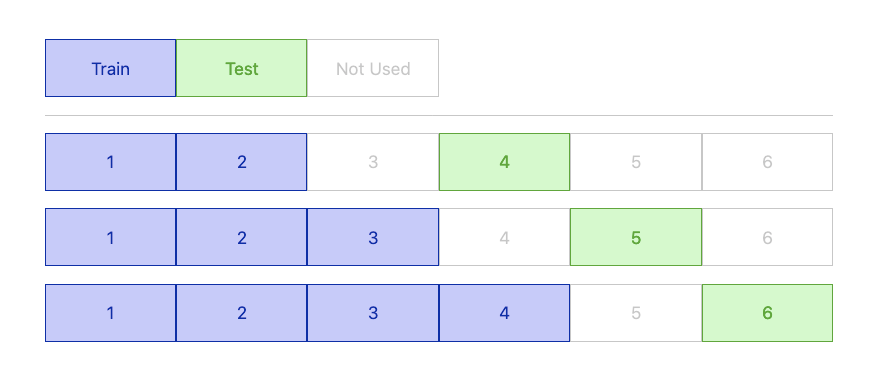

We'll explore data splitting in more depth in the next lesson.

## Further Reading

- [Pandas Documentation: Timeseries](https://pandas.pydata.org/pandas-docs/stable/timeseries.html)
- [Working with Time Series](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html)
- [Pandas Reference for Time Series](https://ds.codeup.com/9-timeseries/working-with-time-series-data-with-pandas/)


## Exercises

The end result of this exercise should be a file named `prepare.py`.

Using your store items data:

1. Convert date column to datetime format.  
1. Plot the distribution of `sale_amount` and `item_price`.  
1. Set the index to be the datetime variable.
1. Add a 'month' and 'day of week' column to your dataframe.
1. Add a column to your dataframe, `sales_total`, which is a derived from `sale_amount` (total items) and `item_price`.  
1. Make sure all the work that you have done above is reproducible. That is, you should put the code above into separate functions and be able to re-run the functions and get the same results.

Using the OPS data acquired in the Acquire exercises `opsd_germany_daily.csv`, complete the following:

1. Convert date column to datetime format.  
1. Plot the distribution of each of your variables.  
1. Set the index to be the datetime variable.  
1. Add a month and a year column to your dataframe.
1. Fill any missing values.
1. Make sure all the work that you have done above is reproducible. That is, you should put the code above into separate functions and be able to re-run the functions and get the same results.